## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему.

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 

#### Жесткий дедлайн: 7.04.25 23:59 MSK (без снижения баллов)

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv`

In [20]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

# !pip3 install gdown


# import gdown
# # train
# url = "https://drive.google.com/file/d/1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-/view?usp=drive_link"
# output = 'train.csv'
# gdown.download(url, output, quiet=False)

# # test
# url = "https://drive.google.com/file/d/11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG/view?usp=drive_link"
# output = 'test.csv'
# gdown.download(url, output, quiet=False)

In [1]:
import gdown
# train
url = "https://drive.google.com/uc?id=1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-"

output = 'train.csv'
gdown.download(url, output, quiet=True)

# test
url = "https://drive.google.com/uc?id=11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG"

output = 'test.csv'
gdown.download(url, output, quiet=True)

# user features
url = "https://drive.google.com/uc?id=1zl2jWMdUhc-IMakHlihQhJ5PGGZm9-_O"
output = 'users.csv'
gdown.download(url, output, quiet=True, fuzzy=True)

# item features
url = "https://drive.google.com/uc?id=1chCmpiCKJRjdqNftHc-t2ALl3qbAp2G8"
output = 'items.csv'
gdown.download(url, output, quiet=True)

'items.csv'

In [ ]:
#!pip install optuna shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 4.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import xgboost as xgb
import shap
import datetime
import matplotlib.pyplot as plt
import time
from typing import Union
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix, coo_array, csr_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
from tqdm import tqdm


RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)



### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно.

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

In [2]:
# 0.  Загружаем файлы, сортируем и разделяем на две части (Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`)

date_columns = ['last_watch_dt']
df_train = pd.read_csv('train.csv', parse_dates=date_columns) #столбец 'last_watch_dt' содержит даты и преобразуем их в формат datetime.
df_test = pd.read_csv('test.csv', parse_dates=date_columns)

df_train = df_train.sort_values('last_watch_dt')

df_train.shape
number_rows = df_train.shape[0]
number_columns = df_train.shape[1]
print('df_train:')
print('Количество строк:', number_rows)
print('Количество столбцов:', number_columns)

df_train:
Количество строк: 4866956
Количество столбцов: 6


In [3]:
# разделим на две части 85/15%. 15%- валидация
split_date = df_train['last_watch_dt'].quantile(0.85)
train_stage_1 = df_train[df_train['last_watch_dt'] < split_date].copy()
valid_stage_1 = df_train[df_train['last_watch_dt'] >= split_date].copy()

train_stage_1.shape
number_rows = train_stage_1.shape[0]
number_columns = train_stage_1.shape[1]
print('train_stage_1:')
print('Количество строк:', number_rows)
print('Количество столбцов:', number_columns)

valid_stage_1.shape
number_rows = valid_stage_1.shape[0]
number_columns = valid_stage_1.shape[1]
print('valid_stage_1:')
print('Количество строк:', number_rows)
print('Количество столбцов:', number_columns)

train_stage_1:
Количество строк: 4090445
Количество столбцов: 6
valid_stage_1:
Количество строк: 776511
Количество столбцов: 6


In [4]:
#  даты DF и смотрим при каких датах произошло разделение при 15% выдеении данных для валидации. 
start_date = df_train['last_watch_dt'].min()
print(f"Начальная дата: {start_date}")
# Последняя дата
end_date = df_train['last_watch_dt'].max()
print(f"Последняя дата: {end_date}")

Начальная дата: 2021-03-13 00:00:00
Последняя дата: 2021-08-12 00:00:00


In [5]:
start_date = train_stage_1['last_watch_dt'].min()
print(f"Начальная дата: {start_date}")
# Последняя дата
end_date = train_stage_1 ['last_watch_dt'].max()
print(f"Последняя дата: {end_date}")

Начальная дата: 2021-03-13 00:00:00
Последняя дата: 2021-07-29 00:00:00


In [6]:
start_date = valid_stage_1['last_watch_dt'].min()
print(f"Начальная дата: {start_date}")
# Последняя дата
end_date = valid_stage_1 ['last_watch_dt'].max()
print(f"Последняя дата: {end_date}")

Начальная дата: 2021-07-30 00:00:00
Последняя дата: 2021-08-12 00:00:00


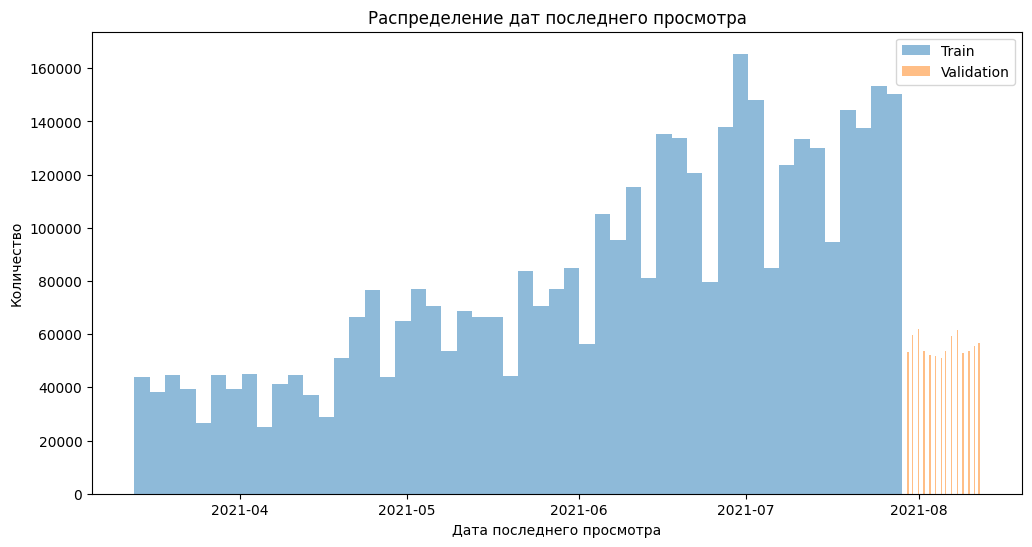

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(train_stage_1['last_watch_dt'], bins=50, alpha=0.5, label='Train')
plt.hist(valid_stage_1['last_watch_dt'], bins=50, alpha=0.5, label='Validation')
plt.xlabel('Дата последнего просмотра')
plt.ylabel('Количество')
plt.title('Распределение дат последнего просмотра')
plt.legend()
plt.show()

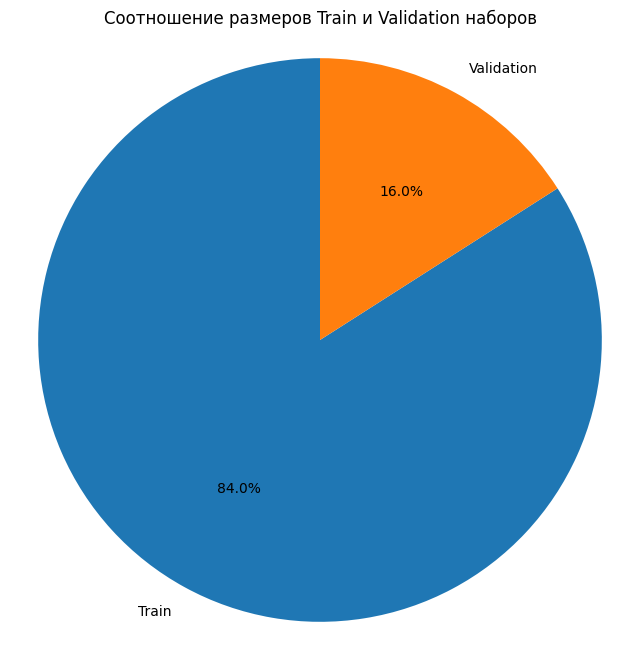

In [8]:
sizes = [len(train_stage_1), len(valid_stage_1)]
labels = ['Train', 'Validation']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Соотношение размеров Train и Validation наборов')
plt.show()

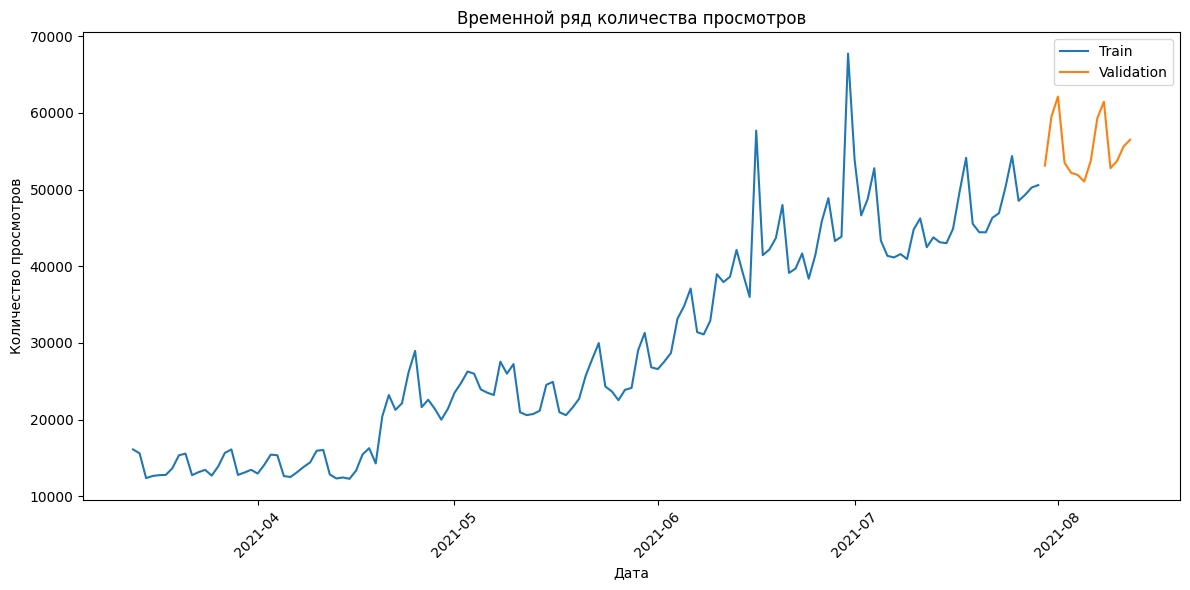

In [9]:
train_counts = train_stage_1['last_watch_dt'].value_counts().sort_index()
valid_counts = valid_stage_1['last_watch_dt'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(train_counts.index, train_counts.values, label='Train')
plt.plot(valid_counts.index, valid_counts.values, label='Validation')
plt.xlabel('Дата')
plt.ylabel('Количество просмотров')
plt.title('Временной ряд количества просмотров')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
df_train.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,310745,13373,2021-03-13,4485,98.0,1
10727,841963,3095,2021-03-13,83,1.0,0
10728,914523,13936,2021-03-13,5503,92.0,1
10729,306374,3095,2021-03-13,2865,44.0,0
10730,505923,3221,2021-03-13,12765,100.0,1


In [12]:
df_test.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,718866,6382,2021-08-13,10309,19.0,0
1,147119,13865,2021-08-13,1666,26.0,0
2,1079425,4141,2021-08-13,774,10.0,0
3,810008,15297,2021-08-13,3,0.0,0
4,1068123,10440,2021-08-13,492,0.0,0


1.1. Эвристическая модель 

In [13]:
class PopularityRecommender:
    def __init__(self, default_score=0):
        self.default_score = default_score
        self.item_popularity = None
        self.user_item_interactions = None
    
    def fit(self, df, target_column=None):
        self.user_item_interactions = df
        if target_column:
            self.item_popularity = df.groupby('item_id')[target_column].sum().reset_index(name='popularity')
        else:
            self.item_popularity = df.groupby('item_id').size().reset_index(name='popularity')
    
    def k_items_top(self, k: int = 100):
        return self.item_popularity.nlargest(k, 'popularity')['item_id'].tolist()
    
    def recommend(self, user_id, top_k=10):
        return self.k_items_top(top_k)
    
    def ui_prediction(self, user_id, item_id):
        popularity_dict = self.item_popularity.set_index('item_id')['popularity'].to_dict()
        return popularity_dict.get(item_id, self.default_score)
    
    # Для обратной совместимости
    predict_relevance = ui_prediction

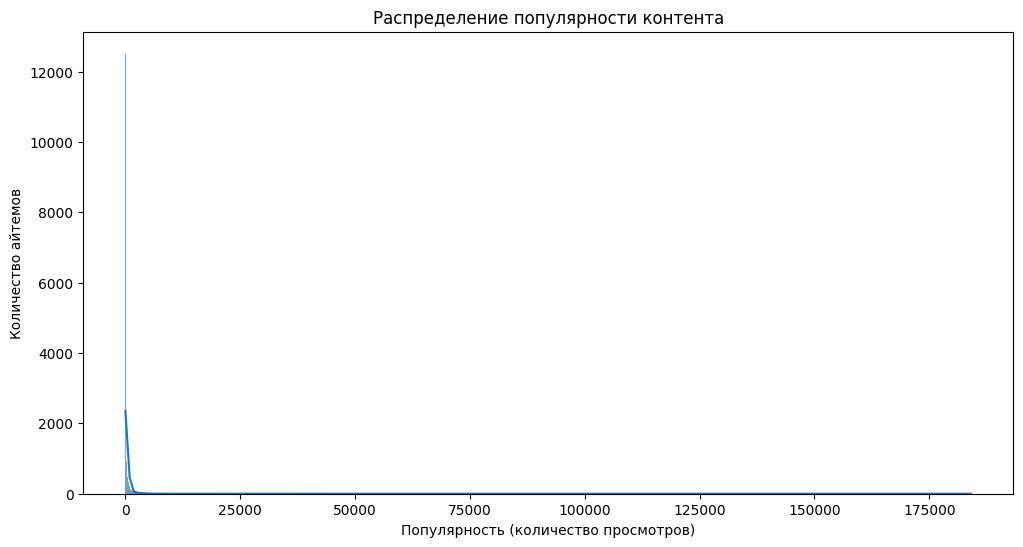

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_popularity_distribution(model):
    plt.figure(figsize=(12,6))
    sns.histplot(model.item_popularity['popularity'], bins=1000, kde=True)
    plt.title('Распределение популярности контента')
    plt.xlabel('Популярность (количество просмотров)')
    plt.ylabel('Количество айтемов')
    plt.show()

# Пример использования
pop_model = PopularityRecommender()
pop_model.fit(df_train)
plot_popularity_distribution(pop_model)

C:\Users\Руслан\AppData\Local\Temp\ipykernel_15884\2941528455.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='popularity', y='item_id', data=top_items, palette='viridis')


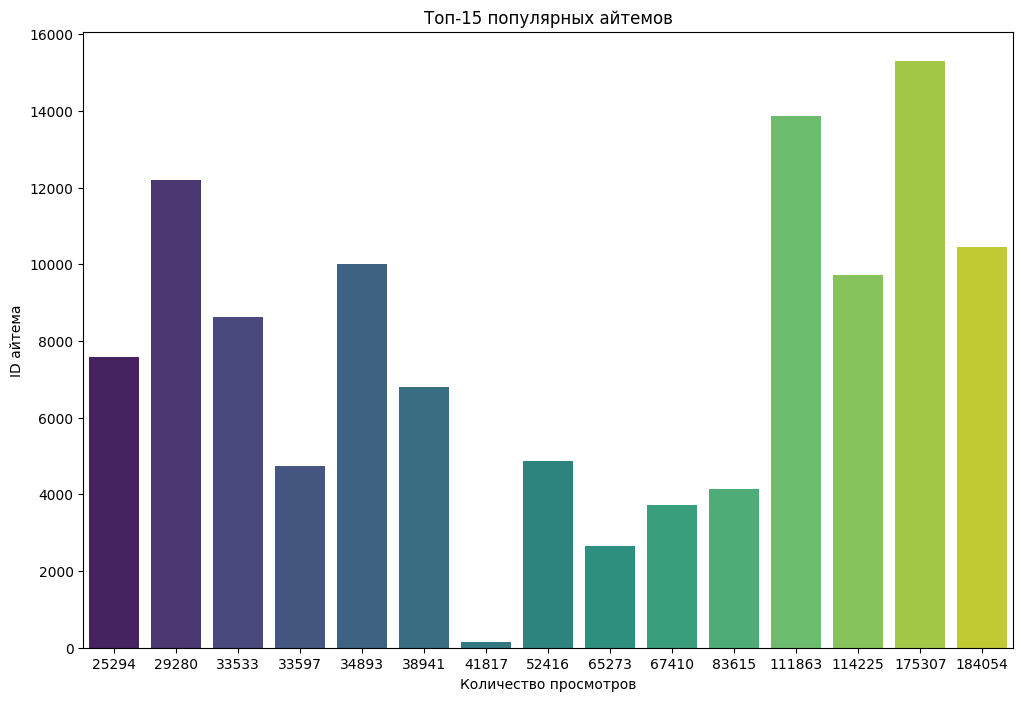

In [15]:
def plot_topn_popular_items(model, n=20):
    top_items = model.item_popularity.nlargest(n, 'popularity')
    
    plt.figure(figsize=(12,8))
    sns.barplot(x='popularity', y='item_id', data=top_items, palette='viridis')
    plt.title(f'Топ-{n} популярных айтемов')
    plt.xlabel('Количество просмотров')
    plt.ylabel('ID айтема')
    plt.show()

plot_topn_popular_items(pop_model, 15)

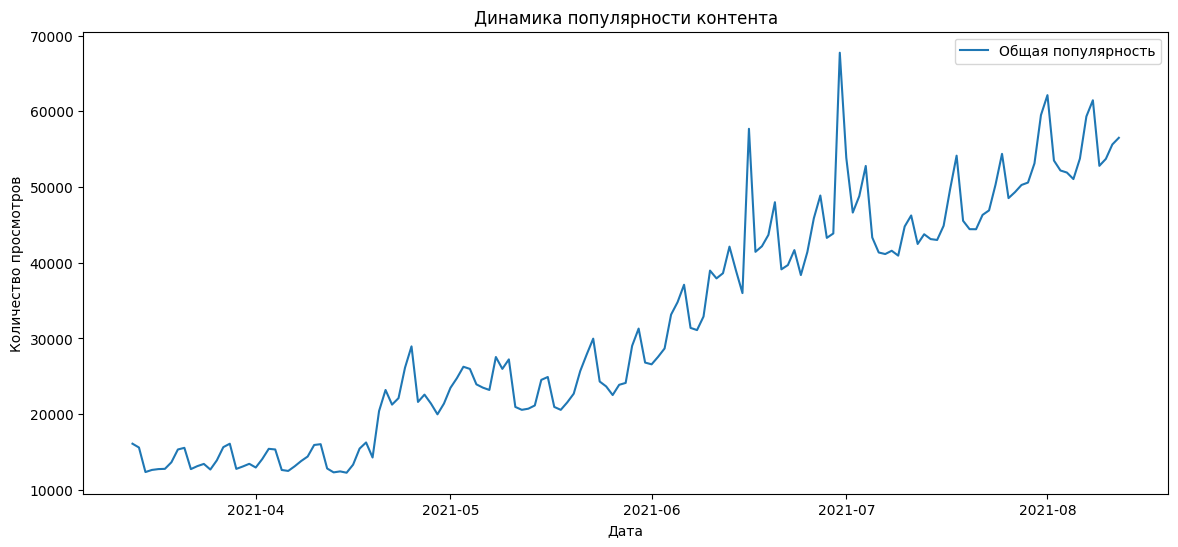

In [16]:
def plot_popularity_trend(model, time_column='watch_dt'):
    df = model.user_item_interactions.copy()
    df['date'] = df[time_column].dt.date
    
    plt.figure(figsize=(14,6))
    df.groupby('date').size().plot(label='Общая популярность')
    plt.title('Динамика популярности контента')
    plt.xlabel('Дата')
    plt.ylabel('Количество просмотров')
    plt.legend()
    plt.show()

plot_popularity_trend(pop_model, 'last_watch_dt')

In [17]:
import time
start_time = time.time()
popularity_recommender_model = PopularityRecommender(default_score=0)
popularity_recommender_model.fit(train_stage_1)
print(f"Работа эвристической модели (в сек.): {time.time() - start_time:.3f}")

Работа эвристической модели (в сек.): 0.103


1.2. Модель матричной факторизации с использованием SVD

In [18]:
from sklearn.decomposition import TruncatedSVD
class SVD_factorization:
    def __init__(self, n_factors=20, default_score=0):
        self.n_factors = n_factors
        self.default_score = default_score
    
    def fit(self, df):
        self.unique_users = df['user_id'].unique()
        self.unique_items = df['item_id'].unique()
        self.user_to_index = {user: idx for idx, user in enumerate(self.unique_users)}
        self.item_to_index = {item: idx for idx, item in enumerate(self.unique_items)}
        rows = df['user_id'].map(self.user_to_index.get)
        cols = df['item_id'].map(self.item_to_index.get)
        data = df['target']
        self.interaction_matrix = csr_matrix((data, (rows, cols)), shape=(len(self.unique_users), len(self.unique_items)))
        self.svd = TruncatedSVD(n_components=self.n_factors, random_state=42)
        self.user_factors = self.svd.fit_transform(self.interaction_matrix)
        self.item_factors = self.svd.components_.T
    
    def ui_prediction(self, user_id, item_id):
        if (user_id not in self.user_to_index) or (item_id not in self.item_to_index):
            return self.default_score
        u_idx = self.user_to_index[user_id]
        i_idx = self.item_to_index[item_id]
        return np.dot(self.user_factors[u_idx], self.item_factors[i_idx])
    
    def recommend(self, user_id, top_k=10):
        if user_id not in self.user_to_index:
            return []
        u_idx = self.user_to_index[user_id]
        predicted_scores = np.dot(self.user_factors[u_idx], self.item_factors.T)
        top_items_idx = np.argsort(predicted_scores)[::-1][:top_k]
        idx2item = {idx: item for item, idx in self.item_to_index.items()}
        return [idx2item[idx] for idx in top_items_idx]
    


In [19]:
start_time = time.time()
svd_factorization_model = SVD_factorization(n_factors=20, default_score=0)
svd_factorization_model.fit(train_stage_1)
print(f"Работа матричной модели (в сек.): {time.time() - start_time:.3f}")

Работа матричной модели (в сек.): 7.460


# 1.3. нейросетевая модель

In [22]:
gpu = torch.cuda.is_available()
device = torch.device("cuda" if gpu else "cpu")
print("Устройство, используемое для работы модели:", device)

Устройство, используемое для работы модели: cpu


In [25]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, num_users, num_items, embedding_user_item=20):
        super(NeuralNetworkModel, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_user_item)
        self.item_embedding = nn.Embedding(num_items, embedding_user_item)
        self.hidden_layer = nn.Linear(embedding_user_item*2, 64)
        self.output_layer = nn.Linear(64, 1)
    
    def forward(self, user_idx, item_idx):
        user_embeddings = self.user_embedding(user_idx)
        item_embeddings = self.item_embedding(item_idx)
        x = torch.cat([user_embeddings, item_embeddings], dim=1)
        x = torch.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x.squeeze()

class NeuralNetworkWrapper:
    def __init__(self, default_score=0, embedding_user_item=20, epochs=4, batch_size=512, lr=0.001):
        self.default_score = default_score
        self.embedding_user_item = embedding_user_item
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
    
    def fit(self, df):
        self.unique_users = df['user_id'].unique()
        self.unique_items = df['item_id'].unique()
        self.user_to_index = {user: idx for idx, user in enumerate(self.unique_users)}
        self.item_to_index = {item: idx for idx, item in enumerate(self.unique_items)}
        num_users = len(self.unique_users)
        num_items = len(self.unique_items)
        self.model = NeuralNetworkModel(num_users, num_items, self.embedding_user_item).to(device)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.MSELoss()
        
        users = df['user_id'].map(self.user_to_index.get).values
        items = df['item_id'].map(self.item_to_index.get).values
        targets = df['target'].values.astype(np.float32)
        dataset = torch.utils.data.TensorDataset(torch.tensor(users, dtype=torch.long),
                                                  torch.tensor(items, dtype=torch.long),
                                                  torch.tensor(targets, dtype=torch.float))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.model.train()
        
        for epoch in range(self.epochs):
            epoch_loss = 0
            for batch_users, batch_items, batch_targets in dataloader:
                batch_users = batch_users.to(device)
                batch_items = batch_items.to(device)
                batch_targets = batch_targets.to(device)
                optimizer.zero_grad()
                outputs = self.model(batch_users, batch_items)
                loss = loss_fn(outputs, batch_targets)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {epoch_loss/len(dataloader):.4f}")
    
    def ui_prediction(self, user_id, item_id):
        if (user_id not in self.user_to_index) or (item_id not in self.item_to_index):
            return self.default_score
        self.model.eval()
        user_idx = torch.tensor([self.user_to_index[user_id]], dtype=torch.long).to(device)
        item_idx = torch.tensor([self.item_to_index[item_id]], dtype=torch.long).to(device)
        with torch.no_grad():
            score = self.model(user_idx, item_idx).item()
        return score
    
    def recommend(self, user_id, top_k=10):
        if user_id not in self.user_to_index:
            return []
        self.model.eval()
        user_idx = self.user_to_index[user_id]
        item_indices = torch.tensor([self.item_to_index[item] for item in self.unique_items], dtype=torch.long).to(device)
        user_tensor = torch.tensor([user_idx] * len(self.unique_items), dtype=torch.long).to(device)
        with torch.no_grad():
            predicted_scores = self.model(user_tensor, item_indices).cpu().numpy()
        top_items_idx = np.argsort(predicted_scores)[::-1][:top_k]
        return [self.unique_items[i] for i in top_items_idx]

In [26]:
start_time = time.time()
neural_networ_model = NeuralNetworkWrapper(default_score=0, embedding_user_item=20, epochs=3, batch_size=1024, lr=0.001)
neural_networ_model.fit(train_stage_1)
print(f"Затраченное время на torch нейросеть {time.time() - start_time} секунд")

Epoch 1/3, Loss: 0.2241
Epoch 2/3, Loss: 0.2115
Epoch 3/3, Loss: 0.1998
Затраченное время на torch нейросеть 1003.7886173725128 секунд



### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)).

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [27]:
items = pd.read_csv('items.csv')
users = pd.read_csv('users.csv')

In [28]:
items.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [29]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [30]:
def calculate_add_features(df, date_historical_df, historical_df):
    # Выбираем исторические данные до date_historical_df
    new_df = historical_df[historical_df['last_watch_dt'] < date_historical_df].copy()
    
    # 2 фичи относящиеся к сущности пользователя
    # avg_watch_pct_by_user  Средний процент просмотра для каждого пользователя
    # num_watch_pct_user Количество просмотров для каждого пользователя.
    user_df = new_df.groupby('user_id').agg(avg_watch_pct_by_user = ('watched_pct', 'mean'), num_watch_pct_user = ('watched_pct', 'count')).reset_index()
    # 2 фичи относящиеся к сущности айтема 
    # avg_watch_pct_by_item Насколько пользователи в среднем досматривают этот айтем. определяет, насколько айтем интересен аудитории в целом
    # num_watch_pct_item Сколько раз айтем был просмотрен
    item_df = new_df.groupby('item_id').agg(avg_watch_pct_by_item = ('watched_pct', 'mean'), num_watch_pct_item = ('watched_pct', 'count')).reset_index()
    # 6 признаков, которые показывают связь пользователя и айтема 
    # Сколько раз пользователь начинал смотреть этот айтем
    # Насколько пользователь в среднем досматривает этот айтем
    user_item_df = new_df.groupby(['user_id', 'item_id']).agg(num_user_item_df = ('watched_pct', 'count'), avg_watch_pct_user_item_df = ('watched_pct', 'mean')).reset_index()
    # Объединяем вычисленные фичи с исходными данными:
    df = df.merge(user_df, on='user_id', how='left')
    df = df.merge(item_df, on='item_id', how='left')
    df = df.merge(user_item_df, on=['user_id', 'item_id'], how='left')
    df['log_user_watch_count'] = np.log1p(df['num_watch_pct_user'])
    df['log_item_watch_count'] = np.log1p(df['num_watch_pct_item'])
    df['prod_user_item_watch_pct'] = df['avg_watch_pct_by_user'] * df['avg_watch_pct_by_item']
    df['diff_user_item_watch_pct'] = df['avg_watch_pct_by_user'] - df['avg_watch_pct_by_item']
    df['ratio_user_item_count'] = df['num_user_item_df'] / (df['num_watch_pct_user'] + 1)
    
    df.fillna(0, inplace=True)
    return df

min_date_valid_historical_df= valid_stage_1['last_watch_dt'].min()
df_train_add = calculate_add_features(valid_stage_1.copy(), min_date_valid_historical_df, train_stage_1)
df_train_add.shape
number_rows = df_train_add.shape[0]
number_columns = df_train_add.shape[1]
print('df_train_add:')
print('Количество строк:', number_rows)
print('Количество столбцов:', number_columns)


min_date_test_historical_df = df_test['last_watch_dt'].min()  
df_test_add = calculate_add_features(df_test.copy(), min_date_test_historical_df, df_train)
df_test_add.shape
number_rows = df_test_add.shape[0]
number_columns = df_test_add.shape[1]
print('df_test_df_add:')
print('Количество строк:', number_rows)
print('Количество столбцов:', number_columns)

df_train_add:
Количество строк: 776511
Количество столбцов: 17
df_test_df_add:
Количество строк: 608467
Количество столбцов: 17


In [31]:
df_train_add

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,avg_watch_pct_by_user,num_watch_pct_user,avg_watch_pct_by_item,num_watch_pct_item,num_user_item_df,avg_watch_pct_user_item_df,log_user_watch_count,log_item_watch_count,prod_user_item_watch_pct,diff_user_item_watch_pct,ratio_user_item_count
0,849573,798,2021-07-30,9892,100.0,1,59.846154,13.0,38.099222,1028.0,0.0,0.0,2.639057,6.936343,2280.091889,21.746932,0.0
1,948358,13865,2021-07-30,263,4.0,0,19.000000,1.0,69.761225,99998.0,0.0,0.0,0.693147,11.512915,1325.463279,-50.761225,0.0
2,298699,2388,2021-07-30,1007,100.0,1,56.333333,6.0,67.369952,619.0,0.0,0.0,1.945910,6.429719,3795.173936,-11.036618,0.0
3,6243,16228,2021-07-30,64858,44.0,0,48.571429,7.0,15.473004,9520.0,0.0,0.0,2.079442,9.161255,751.545918,33.098424,0.0
4,138614,734,2021-07-30,13855,100.0,1,53.550000,20.0,44.955044,2825.0,0.0,0.0,3.044522,7.946618,2407.342619,8.594956,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776506,1085638,9996,2021-08-12,20985,70.0,1,74.000000,5.0,28.964490,30893.0,0.0,0.0,1.791759,10.338317,2143.372285,45.035510,0.0
776507,632245,14362,2021-08-12,5921,100.0,1,33.250000,4.0,68.806639,1205.0,0.0,0.0,1.609438,7.095064,2287.820747,-35.556639,0.0
776508,651541,7829,2021-08-12,753,12.0,0,2.666667,3.0,44.185192,10589.0,0.0,0.0,1.386294,9.267665,117.827179,-41.518526,0.0
776509,1034626,5046,2021-08-12,170,2.0,0,0.000000,0.0,37.278746,861.0,0.0,0.0,0.000000,6.759255,0.000000,0.000000,0.0


In [32]:
df_test_add

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,avg_watch_pct_by_user,num_watch_pct_user,avg_watch_pct_by_item,num_watch_pct_item,num_user_item_df,avg_watch_pct_user_item_df,log_user_watch_count,log_item_watch_count,prod_user_item_watch_pct,diff_user_item_watch_pct,ratio_user_item_count
0,718866,6382,2021-08-13,10309,19.0,0,55.000000,2.0,22.855103,4693.0,0.0,0.0,1.098612,8.454040,1257.030684,32.144897,0.0
1,147119,13865,2021-08-13,1666,26.0,0,0.000000,0.0,68.680699,111863.0,0.0,0.0,0.000000,11.625039,0.000000,0.000000,0.0
2,1079425,4141,2021-08-13,774,10.0,0,37.700000,10.0,59.019287,2748.0,0.0,0.0,2.397895,7.918992,2225.027111,-21.319287,0.0
3,810008,15297,2021-08-13,3,0.0,0,0.000000,0.0,55.291089,175307.0,0.0,0.0,0.000000,12.074300,0.000000,0.000000,0.0
4,1068123,10440,2021-08-13,492,0.0,0,0.000000,0.0,47.377237,184054.0,0.0,0.0,0.000000,12.122990,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608462,1035030,10201,2021-08-22,1154,19.0,0,64.000000,7.0,55.847479,1567.0,0.0,0.0,2.079442,7.357556,3574.238673,8.152521,0.0
608463,574452,2720,2021-08-22,9076,5.0,0,49.290323,31.0,14.115269,6333.0,0.0,0.0,3.465736,8.753687,695.746173,35.175053,0.0
608464,700990,13865,2021-08-22,9010,100.0,1,0.000000,0.0,68.680699,111863.0,0.0,0.0,0.000000,11.625039,0.000000,0.000000,0.0
608465,693510,7571,2021-08-22,3697,64.0,1,0.000000,0.0,55.090575,25294.0,0.0,0.0,0.000000,10.138362,0.000000,0.000000,0.0


In [38]:
if 'popularity_recommender_factor' in df_train_add.columns:
    print("Столбец 'popularity_recommender_factor' существует.")
    print(df_train_add['popularity_recommender_factor'])
else:
    print("Столбец 'popularity_recommender_factor' не существует.")

Столбец 'heuristic_score' не существует.



### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [41]:
df_train_add.head()


,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,avg_watch_pct_by_user,num_watch_pct_user,avg_watch_pct_by_item,num_watch_pct_item,num_user_item_df,avg_watch_pct_user_item_df,log_user_watch_count,log_item_watch_count,prod_user_item_watch_pct,diff_user_item_watch_pct,ratio_user_item_count,popularity_recommender_factor,svd_factorization_model_factor,neural_networ_model_factor
0,849573,798,2021-07-30,9892,100.0,1,59.846154,13.0,38.099222,1028.0,0.0,0.0,2.639057,6.936343,2280.091889,21.746932,0.0,1028,0.000870,0.380786
1,948358,13865,2021-07-30,263,4.0,0,19.000000,1.0,69.761225,99998.0,0.0,0.0,0.693147,11.512915,1325.463279,-50.761225,0.0,99998,0.000000,0.625777
2,298699,2388,2021-07-30,1007,100.0,1,56.333333,6.0,67.369952,619.0,0.0,0.0,1.945910,6.429719,3795.173936,-11.036618,0.0,619,0.003246,0.683333
3,6243,16228,2021-07-30,64858,44.0,0,48.571429,7.0,15.473004,9520.0,0.0,0.0,2.079442,9.161255,751.545918,33.098424,0.0,9520,0.004976,0.155397
4,138614,734,2021-07-30,13855,100.0,1,53.550000,20.0,44.955044,2825.0,0.0,0.0,3.044522,7.946618,2407.342619,8.594956,0.0,2825,0.026838,0.486065


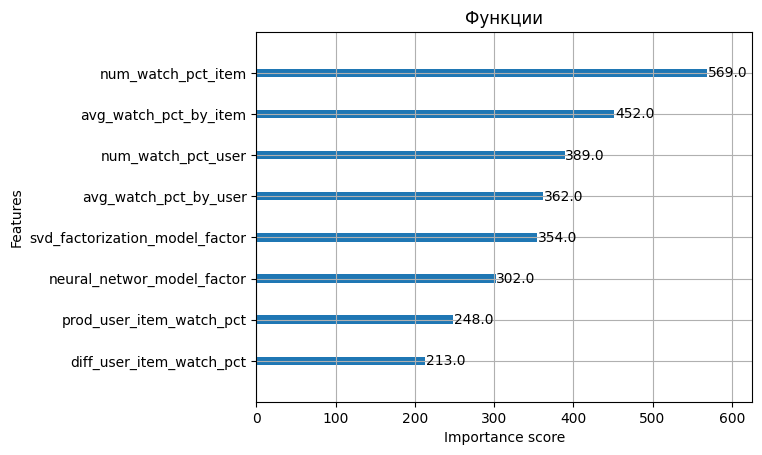

C:\Users\Руслан\AppData\Local\Temp\ipykernel_15884\3517224629.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(feature_contributions, df_train_add[features])


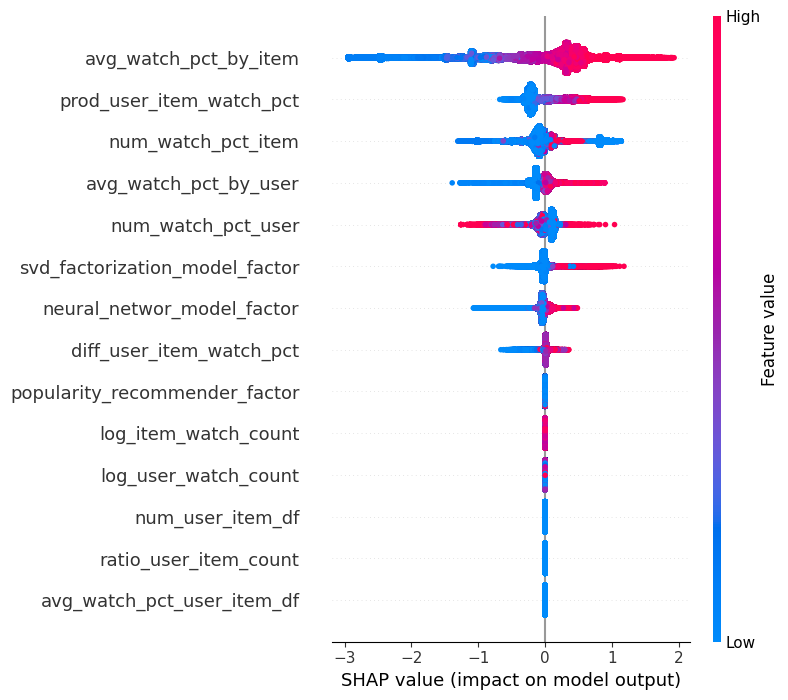

In [42]:
df_train_add['popularity_recommender_factor'] = df_train_add.apply(
    lambda row: popularity_recommender_model.ui_prediction(row['user_id'], row['item_id']), axis=1)
df_train_add['svd_factorization_model_factor'] = df_train_add.apply(
    lambda row: svd_factorization_model.ui_prediction(row['user_id'], row['item_id']), axis=1)
df_train_add['neural_networ_model_factor'] = df_train_add.apply(
    lambda row: neural_networ_model.ui_prediction(row['user_id'], row['item_id']), axis=1)

features = ['avg_watch_pct_by_user', 'num_watch_pct_user', 'avg_watch_pct_by_item', 'num_watch_pct_item',
            'num_user_item_df', 'avg_watch_pct_user_item_df', 'diff_user_item_watch_pct', 'ratio_user_item_count',
            'log_user_watch_count', 'log_item_watch_count', 'prod_user_item_watch_pct', 'popularity_recommender_factor', 'svd_factorization_model_factor', 'neural_networ_model_factor']

created_object = xgb.DMatrix(df_train_add[features], label=df_train_add['target'])
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist' if gpu else 'auto',
    'seed': 42
}
boosting_rounds = 50
boosting_model = xgb.train(params, created_object, num_boost_round=boosting_rounds)

xgb.plot_importance(boosting_model)
plt.title("Функции")
plt.show()

shap_explainer = shap.TreeExplainer(boosting_model)
feature_contributions = shap_explainer.shap_values(df_train_add[features])
shap.summary_plot(feature_contributions, df_train_add[features])


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)

In [43]:

combined_dataset = pd.concat([df_train, df_test])                      # объединяем данные
sorted_dataset = combined_dataset.sort_values('last_watch_dt')         # Сортируем объединеные данных

popularity_recommender_model_combined = PopularityRecommender(default_score=0)
popularity_recommender_model_combined.fit(sorted_dataset)

svd_factorization_model_combined = SVD_factorization(n_factors=20, default_score=0)
svd_factorization_model_combined.fit(sorted_dataset)

neural_networ_model_combined = NeuralNetworkWrapper(default_score=0, embedding_user_item=20, epochs=3, batch_size=1024, lr=0.001)
neural_networ_model_combined.fit(sorted_dataset)



Epoch 1/3, Loss: 0.2198
Epoch 2/3, Loss: 0.2074
Epoch 3/3, Loss: 0.1942


2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)

In [ ]:
number_recommendations = 30 
def get_user_rec_three_model(user_id):
    list_user = set()
    recommender_heuristic = popularity_recommender_model_combined.recommend(user_id, top_k=number_recommendations)
    recommender_factorization = svd_factorization_model_combined.recommend(user_id, top_k=number_recommendations)
    recommender_neural_networ = neural_networ_model_combined.recommend(user_id, top_k=number_recommendations)
    list_user.update(recommender_heuristic)
    list_user.update(recommender_factorization)
    list_user.update(recommender_neural_networ)
    return list(list_user)

unique_user_ids = df_test['user_id'].unique()

list_rec_user_id = {}
for user in unique_user_ids:
    list_rec_user_id[user] = get_user_rec_three_model(user)

3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)

In [ ]:
recomendations_data = []
for user, items in list_rec_user_id.items():
    for item in items:
        factor_popularity_recommender = popularity_recommender_model_combined.predict_score(user, item)
        factor_svd_factorization_model = svd_factorization_model_combined.predict_score(user, item)
        factor_neural_networ_model = neural_networ_model_combined.predict_score(user, item)
        recomendations_data.append({
            'user_id': user,
            'item_id': item,
            'popularity_recommender_factor': factor_popularity_recommender,
            'svd_factorization_model_factor': factor_svd_factorization_model,
            'neural_networ_model_factor': factor_neural_networ_model
        })

recomendations_data_df = pd.DataFrame(recomendations_data)

4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)

In [ ]:
gener_f = combined_dataset['last_watch_dt'].max() + pd.Timedelta(days=1)
recomendations_data_df = calculate_add_features(recomendations_data_df.copy(), gener_f, combined_dataset)

5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)

In [ ]:

test_created_object = xgb.DMatrix(recomendations_data_df[features])
recomendations_data_df['result_pred'] = boosting_model.predict(test_created_object)
number_recommendations_user = 10
recommendations_df = {}
for user in recomendations_data_df['user_id'].unique():
    user_df = recomendations_data_df[recomendations_data_df['user_id'] == user].sort_values('result_pred', ascending=False)
    recommendations_df[user] = user_df.head(number_recommendations_user)['item_id'].tolist()


recommendation_user = list(recommendations_df.keys())[0]
print(f"Recommendations for the user {recommendation_user}: {recommendations_df[recommendation_user]}")

recommendation_items = [item for recs in recommendations_df.values() for item in recs]
calculate_metric_recom = len(set(recommendation_items)) / (number_recommendations_user * len(recommendations_df))
print(f"calculate_metric_recom@{number_recommendations_user}: {calculate_metric_recom}")



6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)

In [ ]:
creating_range_values = range(1, 21)
calculate_metric_recom_list = []
unique_users = recomendations_data_df['user_id'].unique()
start_time = time.time()
for k_val in creating_range_values:
    temp_rec = []
    for user in unique_users:
        user_df = recomendations_data_df[recomendations_data_df['user_id'] == user].sort_values('result_pred', ascending=False)
        recs = user_df.head(k_val)['item_id'].tolist()
        temp_rec.extend(recs)
    calculate_metric_recom_r = len(set(temp_rec)) / (k_val * len(unique_users))
    calculate_metric_recom_list.append(calculate_metric_recom_r)
    print(f"Время {(time.time() - start_time)/60} минут. creating_range_values = {k_val}. calculate_metric_recom = {calculate_metric_recom_r}")

plt.figure(figsize=(8, 5))
plt.plot(creating_range_values, calculate_metric_recom_list, marker='o')
plt.xlabel('creating_range_values')
plt.ylabel('Diversity@creating_range_values')
plt.title('график Diversity от creating_range_values')
plt.grid(True)
plt.show()
